In [12]:
from astropy.io import fits 
import matplotlib.pyplot as plt 
import numpy as np 

We are first going to open our fits file that is, similarly as the observations, going to contain the actual Stokes data and the wavelengths

In [13]:
datacube = fits.open("/home/milic/scratch/cnn_fwd_trainingset/6300_synth.fits")
datacube.info()

Filename: /home/milic/scratch/cnn_fwd_trainingset/6300_synth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (131, 4, 288, 288)   float64   
  1                1 ImageHDU         6   (131,)   float64   


In [14]:
stokes = datacube[0].data
wavelength = datacube[1].data
nl = len(wavelength)
print (stokes.shape)
print (wavelength.shape)
print (wavelength)

(288, 288, 4, 131)
(131,)
[6300.7  6300.72 6300.74 6300.76 6300.78 6300.8  6300.82 6300.84 6300.86
 6300.88 6300.9  6300.92 6300.94 6300.96 6300.98 6301.   6301.02 6301.04
 6301.06 6301.08 6301.1  6301.12 6301.14 6301.16 6301.18 6301.2  6301.22
 6301.24 6301.26 6301.28 6301.3  6301.32 6301.34 6301.36 6301.38 6301.4
 6301.42 6301.44 6301.46 6301.48 6301.5  6301.52 6301.54 6301.56 6301.58
 6301.6  6301.62 6301.64 6301.66 6301.68 6301.7  6301.72 6301.74 6301.76
 6301.78 6301.8  6301.82 6301.84 6301.86 6301.88 6301.9  6301.92 6301.94
 6301.96 6301.98 6302.   6302.02 6302.04 6302.06 6302.08 6302.1  6302.12
 6302.14 6302.16 6302.18 6302.2  6302.22 6302.24 6302.26 6302.28 6302.3
 6302.32 6302.34 6302.36 6302.38 6302.4  6302.42 6302.44 6302.46 6302.48
 6302.5  6302.52 6302.54 6302.56 6302.58 6302.6  6302.62 6302.64 6302.66
 6302.68 6302.7  6302.72 6302.74 6302.76 6302.78 6302.8  6302.82 6302.84
 6302.86 6302.88 6302.9  6302.92 6302.94 6302.96 6302.98 6303.   6303.02
 6303.04 6303.06 6303.08 63

For the sake of exercise, let's neglect the influence of spatial resolution (I already included some spectral resolution), and let's translate these to our photon counts. 

In [15]:
pixel_size = 20E5 #pixel size in cm 
D = 4E2 #telescope diameter in cm 
au = 150E11 # 1 au in cm 
dlambda = (wavelength[1] - wavelength[0]) * 1E-8 #wavelength bin
t_exposure = 1.0

E_photon = 6.626E-27 * 2.997E10 / 6300.0E-8

scaling = pixel_size ** 2.0 * (D*0.5)**2.0 * np.pi / au ** 2.0 * dlambda * t_exposure / E_photon
print (scaling)


1.4174890342993653e-07


In [16]:
# Multiply the Stokes by scaling to get the number of counts
stokes *= scaling

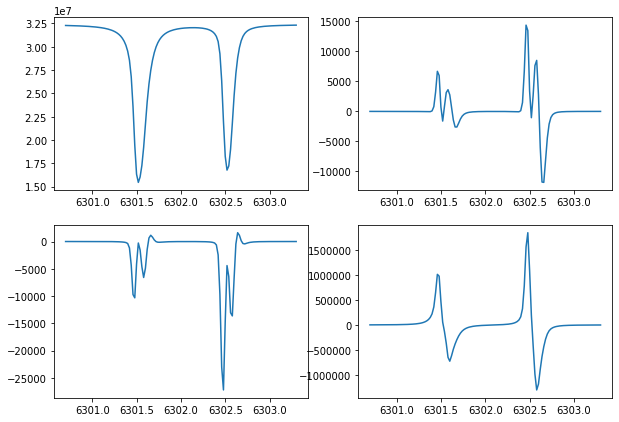

In [17]:
# Let's plot an example Stokes spectrum
x_pixel = 133
y_pixel = 157
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(wavelength,stokes[x_pixel,y_pixel,0])
plt.subplot(222)
plt.plot(wavelength,stokes[x_pixel,y_pixel,1])
plt.subplot(223)
plt.plot(wavelength,stokes[x_pixel,y_pixel,2])
plt.subplot(224)
plt.plot(wavelength,stokes[x_pixel,y_pixel,3])

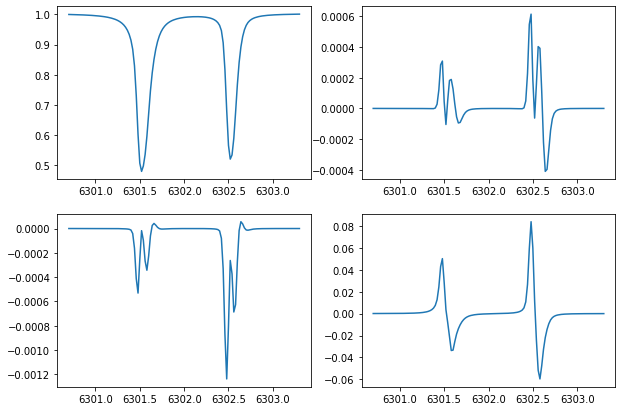

In [18]:
# It's hard to work in these units for Q,U,V
# Let's plot an example Stokes spectrum
x_pixel = 133
y_pixel = 157
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(wavelength,stokes[x_pixel,y_pixel,0]/stokes[x_pixel,y_pixel,0,0])
plt.subplot(222)
plt.plot(wavelength,stokes[x_pixel,y_pixel,1]/stokes[x_pixel,y_pixel,0])
plt.subplot(223)
plt.plot(wavelength,stokes[x_pixel,y_pixel,2]/stokes[x_pixel,y_pixel,0])
plt.subplot(224)
plt.plot(wavelength,stokes[x_pixel,y_pixel,3]/stokes[x_pixel,y_pixel,0])

In [19]:
# Now we will modulate, let's make a modulation matrix. 
# This is a handy function to calculate one row of the modulation function given 
# the orientation of the linear polarizer (theta) and the retardance (delta)

def calc_modulation_row(theta,delta):
    row = np.zeros(4)
    row[0] = 0.5 
    row[1] = 0.5 * np.cos(2.0*theta)
    row[2] = 0.5 * np.cos(delta) * np.sin(2.0*theta)
    row[3] = 0.5 * np.sin(delta) * np.sin(2.0*theta)
    return row.reshape(1,4)

In [34]:
# Let'ss start with a toy model that 
pi = np.pi
O = calc_modulation_row(0,0)
O = np.concatenate([O,calc_modulation_row(pi/2,0)],axis=0)
O = np.concatenate([O,calc_modulation_row(pi/4,0)],axis=0)
O = np.concatenate([O,calc_modulation_row(pi/4,pi/2)],axis=0)
O *= 2.0
print (O)

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00  1.2246468e-16  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  6.1232340e-17  1.0000000e+00]]


In [35]:
#Let's modulate now:

I = stokes[x_pixel,y_pixel]
S_measured_4 = np.zeros([4,nl])
for l in range(0,nl):
    S_measured_4[:,l] = np.dot(O,I[:,l])


[[ 5.00000000e-01  5.00000000e-01 -6.12323400e-17  0.00000000e+00]
 [ 5.00000000e-01 -5.00000000e-01  6.12323400e-17 -0.00000000e+00]
 [-5.00000000e-01 -5.00000000e-01  1.00000000e+00  0.00000000e+00]
 [-5.00000000e-01 -5.00000000e-01 -1.23259516e-32  1.00000000e+00]]


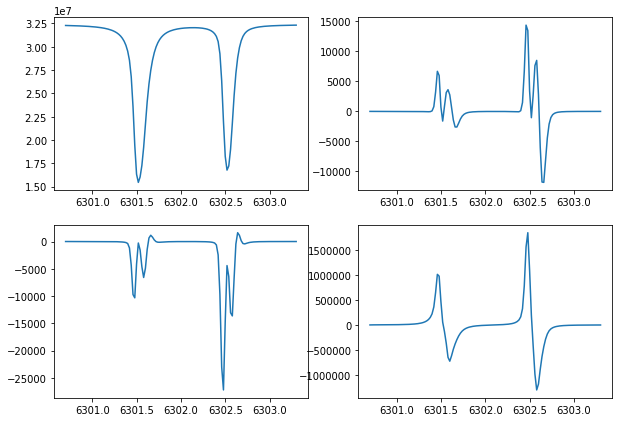

In [37]:
# And now let's demodulate
O_inv = np.linalg.inv(O)
print (O_inv)
I_inferred = np.zeros([4,nl])
for l in range(0,nl):
    I_inferred[:,l] = np.dot(O_inv,S_measured_4[:,l])

# Plot :
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(wavelength,I_inferred[0])
plt.subplot(222)
plt.plot(wavelength,I_inferred[1])
plt.subplot(223)
plt.plot(wavelength,I_inferred[2])
plt.subplot(224)
plt.plot(wavelength,I_inferred[3])

Wow, we got back our Stokes parameters! 

This scheme looks great and intuitive. Why don't we use it then? Well, it is far from optimal. To see that, let's add the noise to our measurement that is proportional to the square root of the signal.

[[ 5.00000000e-01  5.00000000e-01 -6.12323400e-17  0.00000000e+00]
 [ 5.00000000e-01 -5.00000000e-01  6.12323400e-17 -0.00000000e+00]
 [-5.00000000e-01 -5.00000000e-01  1.00000000e+00  0.00000000e+00]
 [-5.00000000e-01 -5.00000000e-01 -1.23259516e-32  1.00000000e+00]]
[0.70710678 0.70710678 0.40824829 0.40824829]


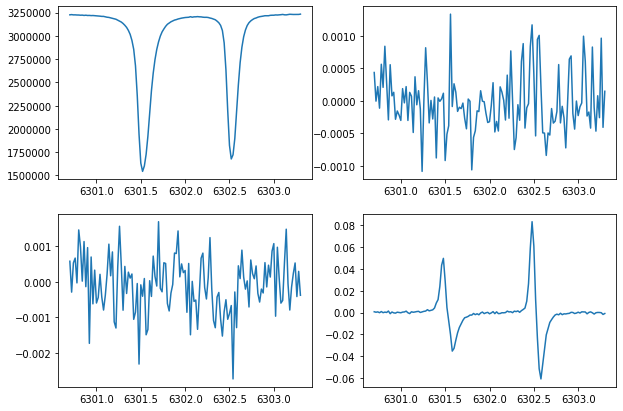

In [38]:
#Let's say that our optical system efficiency is also non-ideal:
S_measured_4[:,:] *= 0.1

for i in range(0,4):
    for l in range (0,nl):
        S_measured_4[i,l] += np.random.randn()*np.sqrt(S_measured_4[i,l])
        
O_inv = np.linalg.inv(O)
print (O_inv)
I_inferred_4 = np.zeros([4,nl])
for l in range(0,nl):
    I_inferred_4[:,l] = np.dot(O_inv,S_measured_4[:,l])

# Plot :
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(wavelength,I_inferred_4[0])
plt.subplot(222)
plt.plot(wavelength,I_inferred_4[1]/I_inferred_4[0])
plt.subplot(223)
plt.plot(wavelength,I_inferred_4[2]/I_inferred_4[0])
plt.subplot(224)
plt.plot(wavelength,I_inferred_4[3]/I_inferred_4[0])

eff = 1.0 / np.sqrt(4.0 * np.sum(O_inv**2.0,axis=1))
print (eff)

So now we see that in reality we will get noisy results. Let's see what happens in we change the modulation scheme.

In [39]:
# This is classic textbook 6-modulation states scheme:

O6 = calc_modulation_row(0,0)
O6 = np.concatenate([O6,calc_modulation_row(pi/2,0)],axis=0)
O6 = np.concatenate([O6,calc_modulation_row(pi/4,0)],axis=0)
O6 = np.concatenate([O6,calc_modulation_row(3.*pi/4,0)],axis=0)
O6 = np.concatenate([O6,calc_modulation_row(pi/4,pi/2)],axis=0)
O6 = np.concatenate([O6,calc_modulation_row(3*pi/4,pi/2)],axis=0)
O6 *= 2.0
print (O6)

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00  1.2246468e-16  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.8369702e-16 -1.0000000e+00 -0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  6.1232340e-17  1.0000000e+00]
 [ 1.0000000e+00 -1.8369702e-16 -6.1232340e-17 -1.0000000e+00]]


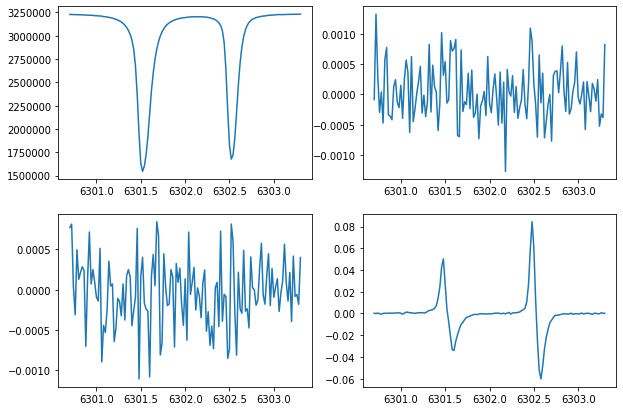

In [45]:
# modulate
I = stokes[x_pixel,y_pixel]
S_measured_6 = np.zeros([6,nl])
for l in range(0,nl):
    S_measured_6[:,l] = np.dot(O6,I[:,l])

# add noise
S_measured_6[:,:] *= 0.1 #throughtput 
for i in range(0,6):
    for l in range (0,nl):
        S_measured_6[i,l] += np.random.randn()*np.sqrt(S_measured_6[i,l])
        
# demodulate:
O6_inv = np.linalg.pinv(O6)
I_inferred_6 = np.zeros([4,nl])
for l in range(0,nl):
    I_inferred_6[:,l] = np.dot(O6_inv,S_measured_6[:,l])
    
# Plot :
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(wavelength,I_inferred_6[0])
plt.subplot(222)
plt.plot(wavelength,I_inferred_6[1]/I_inferred_6[0])
plt.subplot(223)
plt.plot(wavelength,I_inferred_6[2]/I_inferred_6[0])
plt.subplot(224)
plt.plot(wavelength,I_inferred_6[3]/I_inferred_6[0])

In [46]:
eff = 1.0 / np.sqrt(6.0 * np.sum(O6_inv**2.0,axis=1))
print (eff)
print (O6_inv)

[1.         0.57735027 0.57735027 0.57735027]
[[ 1.66666667e-01  1.66666667e-01  1.66666667e-01  1.66666667e-01
   1.66666667e-01  1.66666667e-01]
 [ 5.00000000e-01 -5.00000000e-01  1.55261196e-17 -4.32816952e-17
   1.17851821e-16 -4.58451872e-17]
 [-3.92574231e-18 -2.08240726e-17  5.00000000e-01 -5.00000000e-01
   1.15500678e-16 -4.46088589e-17]
 [ 5.62567857e-17  1.03181215e-16 -3.23981264e-17 -2.31130249e-17
   5.00000000e-01 -5.00000000e-01]]


Let's try and really see the noise!

(-0.0005, 0.0005)

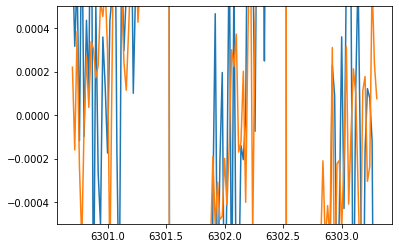

In [49]:
plt.plot(wavelength,I_inferred_4[3]/I_inferred_4[0])
plt.plot(wavelength,I_inferred_6[3]/I_inferred_6[0])
plt.ylim([-5E-4,5E-4])

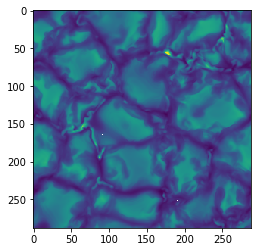

In [27]:
plt.imshow(stokes[:,:,0,0])

In [28]:
O_wrong = np.copy(O)
O_wrong[0,0] *= 0.05
#O[0,1] /= 0.05

I_pure = stokes[:,:,:,0]
I_pure[:,:,1:4] = 0.0
S_measure = np.zeros([288,288,6])
I_inferred = np.zeros([288,288,4])

for i in range(0,288):
    for j in range(0,288):
        S_measure[i,j,:] = np.dot(O_wrong,I_pure[i,j,:])
        I_inferred[i,j,:] = np.dot(O_inv,S_measure[i,j,:])
        

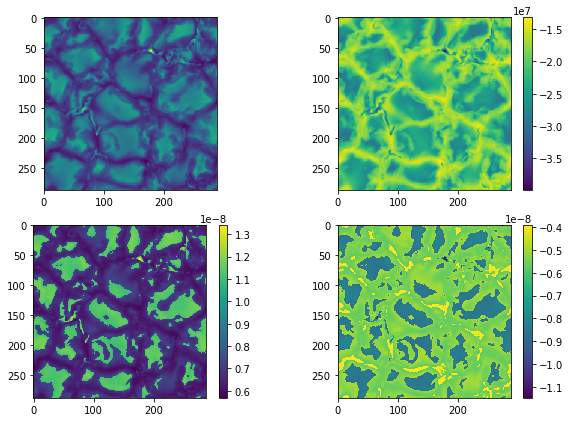

In [203]:
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.imshow(I_inferred[:,:,0])
plt.subplot(222)
plt.imshow(I_inferred[:,:,1],)
plt.colorbar()
plt.subplot(223)
plt.imshow(I_inferred[:,:,2])
plt.colorbar()
plt.subplot(224)
plt.imshow(I_inferred[:,:,3])
plt.colorbar()

In [149]:
print (np.dot(O_inv,O_wrong))

[[ 8.41666667e-01 -1.30659844e-17  2.77555756e-17  0.00000000e+00]
 [-4.75000000e-01  1.00000000e+00 -2.42452519e-18  1.63697009e-16]
 [ 1.81914122e-16  1.39363010e-16  1.00000000e+00  1.60109537e-16]
 [-1.11022302e-16  7.55402508e-17  5.19472385e-17  1.00000000e+00]]
